In [165]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import numpy as np

import catboost as cat
import xgboost as xgb

from collections import Counter


from scipy.fft import fft, fftfreq
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose, STL

from sklearn.cluster import OPTICS
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.feature_selection import SelectKBest, f_regression, f_classif, RFE, SelectFromModel
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from bayes_opt import BayesianOptimization

In [289]:
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)
    return accuracy, precision, recall, f1

def calculate_proportions(array):
    counts = Counter(array)
    total = array.shape[0]
    proportions = {key: val / total for key, val in counts.items()}
    return proportions

def classification_report(predictions, targets, class_names):
    # Calculate the metrics
    accuracy, precision, recall, f1 = calculate_metrics(targets, predictions)

    # Calculate proportions
    pred_proportions = calculate_proportions(predictions)
    target_proportions = calculate_proportions(targets)

    # Map class indices to class names
    index_to_class_name = {index: class_name for index, class_name in enumerate(class_names)}

    # Print the results
    print(f"Accuracy: {accuracy * 100:.2f}%")

    data = []
    for class_index, class_name in index_to_class_name.items():
        row = {
            'Class': class_name,
            'Precision': precision[class_index] * 100,
            'Recall': recall[class_index] * 100,
            'F1-score': f1[class_index] * 100,
            'Prediction Proportion': pred_proportions.get(class_index, 0) * 100,
            'Target Proportion': target_proportions.get(class_index, 0) * 100,
        }
        data.append(row)

    return pd.DataFrame(data)

# Importación del dataset final

In [4]:
df = pd.read_csv('./final_dataset.csv').drop(columns=['Unnamed: 0'])
df['t'] = pd.to_datetime(df['t'])
df = df.set_index(['t', 'symbol'])
df = df.sort_index()
df.head()

,,o,h,l,c,v,n,vw,diff,emaS,emaM,...,time_embed_month_sin,time_embed_month_cos,time_embed_year_sin,time_embed_year_cos,market_correlation,market_long_term_trend,market_short_term_trend,market_change,alpha,beta
t,symbol,,,,,,,,,,,,,,,,,,,,,
2018-01-02 09:00:00,BABA,173.46,173.90,173.03,173.77,12094,92,173.478710,1.004939,1.000886,1.000067,...,0.000000,1.000000,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02 10:00:00,BABA,173.90,174.00,173.83,174.00,7456,28,173.896286,1.002407,1.001139,1.000127,...,0.008727,0.999962,0.000717,1.000000,1.000000,1.000046,1.000046,NaN,NaN,NaN
2018-01-02 11:00:00,BABA,174.15,174.70,174.02,174.58,9966,93,174.341312,1.002559,1.001376,1.000190,...,0.017452,0.999848,0.001435,0.999999,0.895350,1.000505,1.000540,0.697924,NaN,NaN
2018-01-02 12:00:00,BABA,174.50,174.98,174.25,174.72,65516,405,174.598031,1.001473,1.001392,1.000223,...,0.026177,0.999657,0.002152,0.999998,0.933935,1.000610,1.000648,0.417496,NaN,NaN
2018-01-02 13:00:00,BABA,174.68,175.33,174.40,175.00,105976,696,174.928519,1.001893,1.001475,1.000265,...,0.034899,0.999391,0.002869,0.999996,0.963070,1.000622,1.000650,0.082915,NaN,NaN


Magnitud media de la variación de TSLA a través del tiempo

/var/folders/4z/l7kc3ncn7g3628qd59lkh1km0000gn/T/ipykernel_20710/1698103233.py:1: FutureWarning:

Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['category', 'hv_cat'], dtype='object')



<AxesSubplot:xlabel='t,symbol'>

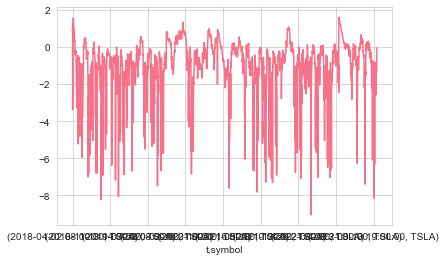

In [229]:
np.log(df.groupby('symbol').get_group('TSLA').ewm(span=500).mean().abs()['pc12']).plot()

/var/folders/4z/l7kc3ncn7g3628qd59lkh1km0000gn/T/ipykernel_20710/4230688116.py:6: FutureWarning:

Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['category', 'hv_cat', 'symbol'], dtype='object')



<AxesSubplot:xlabel='time', ylabel='$\\log{\\frac{v_{d+1}}{v_d}}$'>

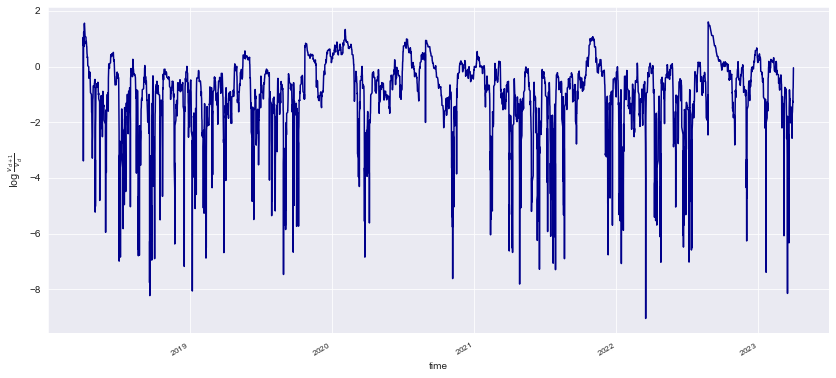

In [242]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rc('text', usetex=False)
sns.set_style('darkgrid')
data = np.log(df.groupby('symbol').get_group('TSLA').reset_index().set_index('t').ewm(span=500).mean().abs()['pc12'])
plt.figure(figsize=(14, 6)) # Increase the figure size to 10x6 inches
plt.xticks(rotation=30, ha='right', fontsize=8)
plt.xlabel('time')

plt.rc('text', usetex=True)
plt.ylabel(r'$\log{\frac{v_{d+1}}{v_d}}$')
sns.lineplot(data=data, color='darkblue') # Set the line colour to dark blue


<AxesSubplot:>

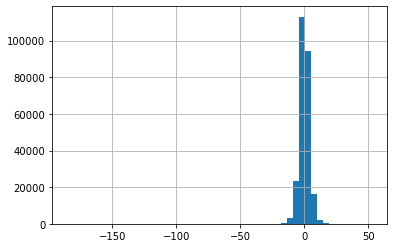

In [6]:
df['pc12'].hist(bins=50)

Top 20 valores PC12

In [7]:
df.reset_index()
df = df.sort_values('pc12')
df['pc12'].head(20)

t                    symbol
2020-08-28 16:00:00  AAPL     -184.750071
2020-08-28 23:00:00  AAPL     -184.596963
2020-08-28 19:00:00  AAPL     -184.265316
2020-08-28 15:00:00  AAPL     -184.231121
2020-08-28 18:00:00  AAPL     -184.055697
2020-08-28 17:00:00  AAPL     -183.823395
2020-08-28 22:00:00  AAPL     -183.693278
2020-08-28 14:00:00  AAPL     -183.454955
2020-08-28 20:00:00  AAPL     -183.117767
2020-08-28 21:00:00  AAPL     -183.108576
2020-08-28 13:00:00  AAPL     -182.843224
2020-08-28 12:00:00  AAPL     -182.328986
2022-07-15 23:00:00  GOOG     -167.303292
2022-07-15 21:00:00  GOOG     -166.804772
2022-07-15 20:00:00  GOOG     -166.225505
2022-07-15 19:00:00  GOOG     -165.731233
2022-07-15 18:00:00  GOOG     -165.239768
2022-07-15 17:00:00  GOOG     -164.780019
2022-07-15 15:00:00  GOOG     -164.267377
2022-07-15 16:00:00  GOOG     -164.259897
Name: pc12, dtype: float64

Bottom 5 valores PC12

In [8]:
df['pc12'].tail()

t                    symbol
2023-02-01 10:00:00  META      51.484519
2023-02-01 20:00:00  META      52.084823
2023-02-01 12:00:00  META      52.233970
2023-02-01 13:00:00  META      52.360424
2023-02-01 19:00:00  META      52.801748
Name: pc12, dtype: float64

## Metodo de categorización 1
Este es el malo, calcula los percentiles generales y agrupa cada instancia en su respectivo grupo

In [9]:
df.sort_values('pc12')
top_value = df['pc12'].quantile(0.95)
bottom_value = df['pc12'].quantile(0.05)

df['category'] = 'middle'
df.loc[df['pc12'] > top_value, 'category'] = 'top'
df.loc[df['pc12'] < bottom_value, 'category'] = 'bottom'

## Metodo 2
Este es el bueno, calcula unos thresholds dinamicos en función de la aproximación de la función de distribución gaussiana para detectar el top 5% y bottom 5% de las instancias de manera contextual. És decir, que en función del contexto del activo en cada momento estima cuales són los valores más extremos que pueden suceder.

In [269]:
from scipy.stats import norm
df = df.sort_index()

# Define the threshold percentile
threshold_percentile = 4
rolling_window = 77

# Compute the rolling mean and standard deviation for each symbol
df['rolling_mean'] = df.groupby('symbol')['pc12'].transform(lambda x: x.rolling(window=rolling_window).mean())
df['rolling_std'] = df.groupby('symbol')['pc12'].transform(lambda x: x.rolling(window=rolling_window).std())

# Compute the upper and lower threshold values for each symbol
df['upper_threshold'] = df['rolling_mean'] + df['rolling_std'] * norm.ppf(1 - threshold_percentile / 100)
df['lower_threshold'] = df['rolling_mean'] - df['rolling_std'] * norm.ppf(1 - threshold_percentile / 100)

# Assign the category based on the thresholds
df['category'] = 'middle'
df.loc[df['pc12'] > df['upper_threshold'], 'category'] = 'top'
df.loc[df['pc12'] < df['lower_threshold'], 'category'] = 'bottom'

df['category'] = df['category'].astype('category')

# Drop the intermediate columns
df.drop(['rolling_mean', 'rolling_std', 'upper_threshold', 'lower_threshold'], axis=1, inplace=True)

Porcentages finales de cada clase:

In [270]:
year = 2022
res = df[df.index.get_level_values('t').year == year].value_counts('category') * 100 / len(df[df.index.get_level_values('t').year == year])

res['middle']

87.58971776006908

In [271]:
amounts = {
    'top': [],
    'middle': [],
    'bottom': [],
}
for year in [2018, 2019, 2020, 2021, 2022, 2023]:
    res = df[df.index.get_level_values('t').year == year].value_counts('category') * 100 / len(df[df.index.get_level_values('t').year == year])
    amounts['top'].append(res['top'])
    amounts['middle'].append(res['middle'])
    amounts['bottom'].append(res['bottom'])

res = df.value_counts('category')

print(f"Mean of 'top' values by year:    {np.mean(amounts['top']):.3f}%")
print(f"Std of 'top' values by year:     {np.std(amounts['top']):.3f}%")

print(f"\nMean of 'middle' values by year: {np.mean(amounts['middle']):.3f}%")
print(f"Std of 'middle' values by year:  {np.std(amounts['middle']):.3f}%")

print(f"\nMean of 'bottom' values by year: {np.mean(amounts['bottom']):.3f}%")
print(f"Std of 'bottom' values by year:  {np.std(amounts['bottom']):.3f}%")

Mean of 'top' values by year:    5.769%
Std of 'top' values by year:     0.231%

Mean of 'middle' values by year: 88.214%
Std of 'middle' values by year:  0.547%

Mean of 'bottom' values by year: 6.017%
Std of 'bottom' values by year:  0.416%


In [272]:
df.columns

Index(['o', 'h', 'l', 'c', 'v', 'n', 'vw', 'diff', 'emaS', 'emaM', 'emaL',
       'std', 'pc', 'pc12', 'mvS', 'mvL', 'mnS', 'mnL', 'rsi', 'rsid', 'rlmS',
       'rlmL', 'rlmD', 'obv', 'obvmS', 'obvmL', 'obvsL', 'obvSH', 'lavgv',
       'lavm', 'lavs', 'avgv', 'ewm_12', 'ewm_26', 'macd', 'signal',
       'macd_std', 'macds', 'financial_data_age', 'P/E', 'P/S', 'P/B',
       'EPS_Growth', 'ROE', 'ROA', 'Gross_Margin', 'Operating_Margin',
       'Net_Profit_Margin', 'Current_Ratio', 'Debt_to_Equity', 'FCF',
       'spy_value', 'time_embed_day_sin', 'time_embed_day_cos',
       'time_embed_week_sin', 'time_embed_week_cos', 'time_embed_month_sin',
       'time_embed_month_cos', 'time_embed_year_sin', 'time_embed_year_cos',
       'market_correlation', 'market_long_term_trend',
       'market_short_term_trend', 'market_change', 'alpha', 'beta', 'category',
       'hv_cat'],
      dtype='object')

---

# Preparación del dataset

Primero se calcula el punto en el que dividir el dataset a partir de un threshold temporal que divida en un 80/20 el rango general de timestamps del dataset

In [273]:
# Codigo para detectar altas variaciones
df['hv_cat'] = 'low'
df['hv_cat'].loc[(df['category'] == 'bottom') | (df['category'] == 'top')] = 'high'

/var/folders/4z/l7kc3ncn7g3628qd59lkh1km0000gn/T/ipykernel_20710/3864047294.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [274]:
df['category'].value_counts()

middle    223834
bottom     15606
top        14825
Name: category, dtype: int64

In [275]:
df['hv_cat'].value_counts()

low     223834
high     30431
Name: hv_cat, dtype: int64

In [276]:
df.index.get_level_values('t').min()
df.index.get_level_values('t').max()

timestamps = df.index.get_level_values('t')
min_timestamp = timestamps.min()
max_timestamp = timestamps.max()

# Find the timestamp that is 80% of the way between the min and max
threshold_timestamp_val = min_timestamp + 0.6 * (max_timestamp - min_timestamp)
threshold_timestamp_test = min_timestamp + 0.85 * (max_timestamp - min_timestamp)
print("60% division timestamp:", threshold_timestamp_val)
print("85% division timestamp:", threshold_timestamp_test)

60% division timestamp: 2021-02-24 03:00:00
85% division timestamp: 2022-06-17 18:30:00


Aquí se puede hacer una primera selección de atributos aunque de momento no se haga nada :)

In [277]:
"""
columns = [
    'pc', 'emaL', 'emaS', 'mvS', 'rsi', 'macds', 'lavs', 'Net_Profit_Margin', 'market_correlation',
    'Gross_Margin', 'P/E', 'time_embed_year_sin', 'time_embed_year_cos', 'financial_data_age', 'obvmL'
]
"""
columns = df.columns

Aqui se divide ya el dataset separando los dataframes directamente en vez de hacerlo con el classico train/test split de toda la vida. Esto es así ya que se desea preprocesar el data_train por separado.

In [278]:
data = df[columns].dropna()
data_train = data[data.index.get_level_values('t') <= threshold_timestamp_val]
data_val = data[(data.index.get_level_values('t') > threshold_timestamp_val) & (data.index.get_level_values('t') <= threshold_timestamp_test)]
data_test = data[data.index.get_level_values('t') > threshold_timestamp_test]

Aqui se hace un downsample de los datos de train para balancear las categorias. La gràcia está en coger tantas instancias como la classe de la que hay menos datos. La idea principalmente es mejorar la velocidad de computo y dar más importáncia a las classes top y bottom. Aunque se puede explorar otras alternativas

In [279]:
def downsample_dataset(df, target_col):
    k = df.value_counts(target_col).min()
    downsampled_df = pd.DataFrame()
    for category in df[target_col].unique():
        sampled_rows = df[df[target_col] == category].sample(k)
        downsampled_df = pd.concat([downsampled_df, sampled_rows])
    
    return downsampled_df

col = 'category'

downsampled_train = downsample_dataset(data_train, col)
downsampled_val = downsample_dataset(data_val, col)

print(downsampled_train.shape)
print(downsampled_train.value_counts(col))
print("")
print(downsampled_val.shape)
print(downsampled_val.value_counts(col))

(20016, 68)
category
bottom    6672
middle    6672
top       6672
dtype: int64

(10677, 68)
category
bottom    3559
middle    3559
top       3559
dtype: int64


Aqui ya sí que se divide los datasets y se escala los datos

In [280]:
# X = data[columns].drop(columns=['pc12'])
# y = data['pc12']

X_train_raw = downsampled_train[columns].drop(columns=['pc12', 'category', 'hv_cat'])
y_train = downsampled_train['category']

X_val_raw = downsampled_val[columns].drop(columns=['pc12', 'category', 'hv_cat'])
y_val = downsampled_val['category']

X_test_raw = data_test[columns].drop(columns=['pc12', 'category', 'hv_cat'])
y_test = data_test['category']

labels_scaler = StandardScaler()
X_train = pd.DataFrame(labels_scaler.fit_transform(X_train_raw), columns=X_train_raw.columns)
X_val = pd.DataFrame(labels_scaler.transform(X_val_raw), columns=X_train_raw.columns)
X_test = pd.DataFrame(labels_scaler.transform(X_test_raw), columns=X_train_raw.columns)

# targets_scaler = StandardScaler()
# y_train_scaled = targets_scaler.fit_transform(y_train.to_numpy().reshape(-1, 1))
# y_test_scaled = targets_scaler.transform(y_test.to_numpy().reshape(-1, 1))

print("Train:")
print(X_train.shape)
print(y_train.shape)
print("\nValidation:")
print(X_val.shape)
print(y_val.shape)
print("\nTest:")
print(X_test.shape)
print(y_test.shape)

Train:
(20016, 65)
(20016,)

Validation:
(10677, 65)
(10677,)

Test:
(37369, 65)
(37369,)


In [281]:
X_train.isna().sum().sort_values()

o                     0
signal                0
macd_std              0
macds                 0
financial_data_age    0
                     ..
lavgv                 0
lavm                  0
lavs                  0
ewm_12                0
beta                  0
Length: 65, dtype: int64

Se prepara y entrena un Random Forest basico

In [20]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

Se visualiza la matriz de confusión

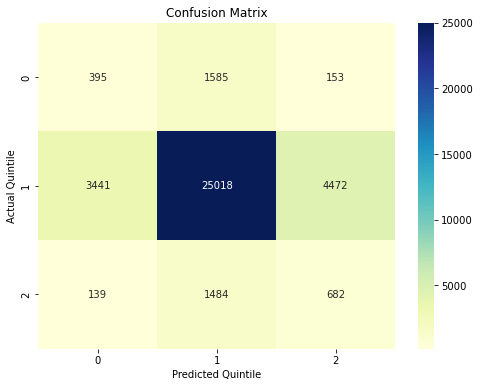

In [21]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sn.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=ax)
ax.set_xlabel("Predicted Quintile")
ax.set_ylabel("Actual Quintile")
ax.set_title("Confusion Matrix")
plt.show()

---

Esto esta interesante, son metodos varios de calculo de seleccion de atributos:

In [282]:
kbest = SelectKBest(score_func=f_classif, k=10)
X_train_kbest = kbest.fit_transform(X_train, y_train)
X_test_kbest = kbest.transform(X_test)
column_names_skb = X_train.columns[kbest.get_support()]
print(f"Columns selected by SelectKBest:\n -> {list(column_names_skb)}")

Columns selected by SelectKBest:
 -> ['emaS', 'emaM', 'emaL', 'rsi', 'obvSH', 'macd', 'signal', 'market_long_term_trend', 'market_short_term_trend', 'alpha']


/var/folders/4z/l7kc3ncn7g3628qd59lkh1km0000gn/T/ipykernel_20710/2680608447.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



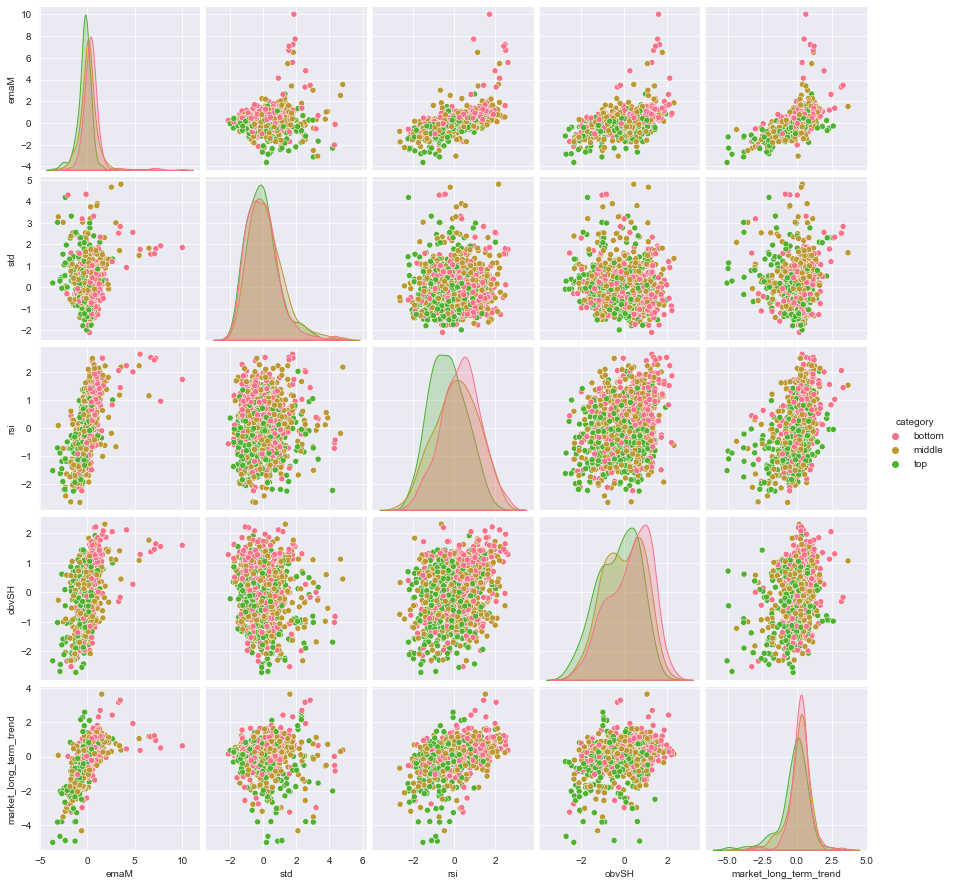

In [283]:
data = X_train[['emaM', 'std', 'rsi', 'obvSH', 'market_long_term_trend']]
data.loc[:, 'category'] = y_train.reset_index()['category']
sn.pairplot(data = data.sample(1000), hue='category')

/var/folders/4z/l7kc3ncn7g3628qd59lkh1km0000gn/T/ipykernel_20710/3556166054.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



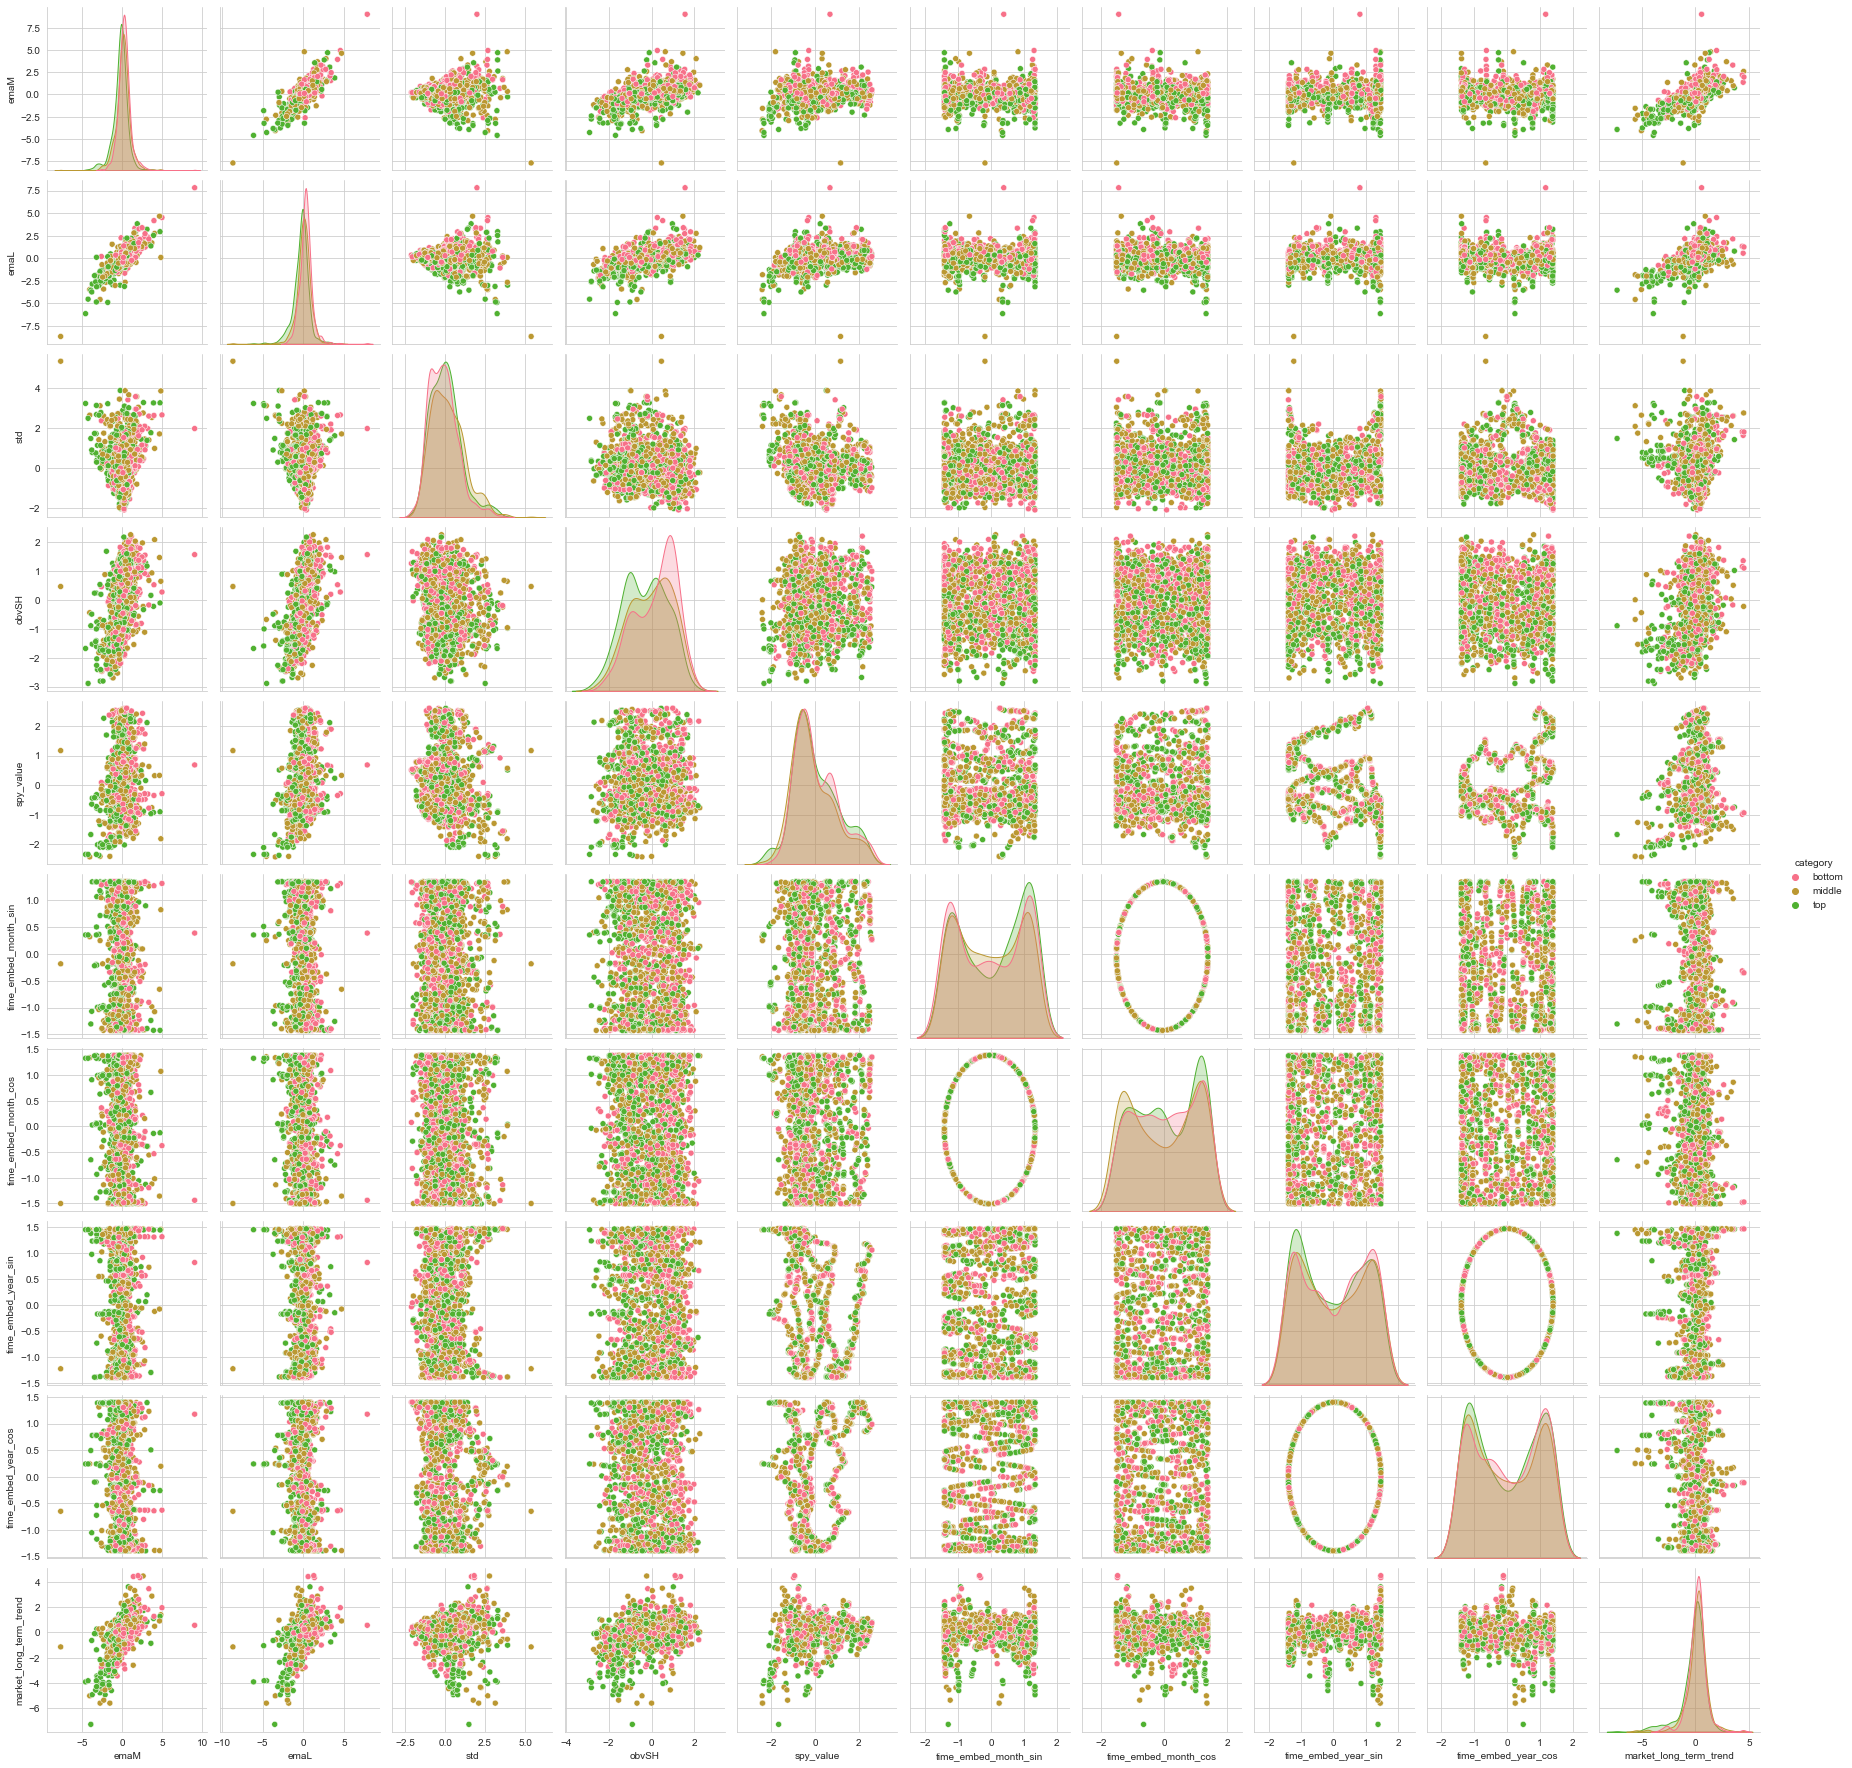

In [228]:
# cols = ['emaS', 'emaM', 'emaL', 'rsi', 'obvSH', 'macd', 'signal', 'macds', 'market_correlation', 'beta']
cols = ['emaM', 'emaL', 'std', 'obvSH', 'spy_value', 'time_embed_month_sin', 'time_embed_month_cos', 'time_embed_year_sin', 'time_embed_year_cos', 'market_long_term_trend']
data = X_train[cols]
data.loc[:, 'category'] = y_train.reset_index()['category']
sn.pairplot(data = data.sample(2000), hue='category')

In [211]:
model = RandomForestClassifier(
    max_depth=5,
    n_estimators=400,
    min_samples_split=2,
    verbose=True,
    n_jobs=-1
)

print("Fitting RF")
model.fit(X_train, y_train)

print("Selecting attrs")
selector = SelectFromModel(model, prefit=True, max_features=10)  # Choose the top 10 features
X_train_importance = selector.transform(X_train)
X_test_importance = selector.transform(X_test)

column_names_importance = X_train_scaled.columns[selector.get_support()]
print("Columns selected by feature importance:", column_names_importance)

Fitting RF


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.9s


Selecting attrs
Columns selected by feature importance: Index(['emaS', 'emaM', 'emaL', 'rsi', 'obvSH', 'macd', 'signal', 'macds',
       'market_long_term_trend', 'beta'],
      dtype='object')


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    4.0s finished
/Users/miquelsaula/mambaforge/envs/TradingStrategies2/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/miquelsaula/mambaforge/envs/TradingStrategies2/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [227]:
rfe = RFE(
    RandomForestClassifier(
        max_depth=5,
        n_estimators=50,
        min_samples_split=2,
        verbose=False,
        n_jobs=-1
    ),
    n_features_to_select=10
)
rfe.fit(X_train, y_train)
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

column_names_rfe = X_train.columns[rfe.get_support()]
print("Columns selected by RFE:", column_names_rfe)

Columns selected by RFE: Index(['emaM', 'emaL', 'std', 'obvSH', 'spy_value', 'time_embed_month_sin',
       'time_embed_month_cos', 'time_embed_year_sin', 'time_embed_year_cos',
       'market_long_term_trend'],
      dtype='object')


# All data

- selection 1: [
    'diff', 'pc', 'rsi', 'rsid', 'macds', 'financial_data_age', 'time_embed_week_sin',
    'time_embed_week_cos', 'time_embed_month_cos', 'market_change'
]
- selection 2: [
    'emaL', 'std', 'obvmS', 'obvmL', 'obvSH', 'lavgv', 'macd_std',
    'financial_data_age', 'spy_value', 'time_embed_year_cos'
]
- selection 3: [
    'emaL', 'std', 'obvmS', 'obvmL', 'ewm_26', 'financial_data_age',
    'spy_value', 'time_embed_year_sin', 'time_embed_year_cos', 'market_correlation'
]

---

# Only big ops
- selection 1: ['emaS', 'emaM', 'emaL', 'rsi', 'obvSH', 'macd', 'signal', 'market_long_term_trend', 'market_short_term_trend', 'alpha']
- selection 2: ['emaS', 'emaM', 'emaL', 'rsi', 'obvSH', 'macd', 'signal', 'macds', 'market_long_term_trend', 'beta']
- selection 3: ['emaS', 'emaM', 'emaL', 'rsi', 'obvSH', 'macd', 'signal', 'macds', 'market_correlation', 'beta']
- selection cb + shap: ['v', 'n', 'diff', 'emaS', 'emaM', 'pc', 'rsi', 'rsid', 'ewm_26', 'macd', 'signal', 'macds', 'time_embed_day_sin', 'market_change', 'beta']


---

In [22]:
from sklearn.metrics import precision_score

class CustomPrecision:
    def get_final_error(self, error, weight):
        return error / (weight + 1e-38)

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 3
        assert len(target) == len(approxes[0])

        approxes = np.array(approxes).T
        y_pred = np.argmax(approxes, axis=1)
        target = np.array(target)

        precision_a = precision_score(target == 0, y_pred == 0)
        precision_c = precision_score(target == 2, y_pred == 2)

        return (precision_a + precision_c) / 2, 1

In [240]:
val_samples = int(len(X_train_scaled) * 0.7)

X_model_train = X_train_scaled[:val_samples]
y_model_train = y_train[:val_samples]
X_model_val = X_train_scaled[val_samples:]
y_model_val = y_train[val_samples:]

print(f"X_model_train: {X_model_train.shape}")
print(f"y_model_train: {y_model_train.shape}")
print(f"X_model_val: {X_model_val.shape}")
print(f"y_model_val: {y_model_val.shape}")

X_model_train: (20162, 65)
y_model_train: (20162,)
X_model_val: (8641, 65)
y_model_val: (8641,)


In [30]:
model = cat.CatBoostClassifier(
    iterations=40000,
    learning_rate=0.01,
    early_stopping_rounds=1000,
    verbose=1000
)

xcols = [
    'emaS', 'emaM', 'emaL', 'rsi', 'obvSH', 'macd', 'signal', 'market_long_term_trend', 
    'market_short_term_trend', 'alpha', 'beta', 'market_correlation'
]
model.fit(
    cat.Pool(
        X_train[xcols],
        y_train
    ),
    eval_set=cat.Pool(
        X_val[xcols],
        y_val
    ),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.0971061	test: 1.0973378	best: 1.0973378 (0)	total: 5.7ms	remaining: 3m 48s
1000:	learn: 0.9156176	test: 1.0168796	best: 1.0159634 (763)	total: 4.08s	remaining: 2m 38s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 1.015963404
bestIteration = 763

Shrink model to first 764 iterations.


In [43]:
from sklearn.preprocessing import LabelEncoder

model = xgb.XGBClassifier(
    n_estimators=1500,
    learning_rate=0.15,
    early_stopping_rounds=100,
    verbosity=1
)

xcols = ['v', 'n', 'diff', 'emaS', 'emaM', 'pc', 'rsi', 'rsid', 'ewm_26', 'macd', 'signal', 'macds', 'time_embed_day_sin', 'market_change', 'beta']
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

model.fit(
    X_train[xcols],
    y_train_encoded,
    eval_set=[(X_val[xcols], y_val_encoded)],
    eval_metric='mlogloss',  # multi-class log loss
    verbose=100
)

[0]	validation_0-mlogloss:1.08105


/Users/miquelsaula/mambaforge/envs/TradingStrategies2/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[100]	validation_0-mlogloss:1.04643
[116]	validation_0-mlogloss:1.05169


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=100,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1500, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

0.4855296431581905
0.4898726500909642


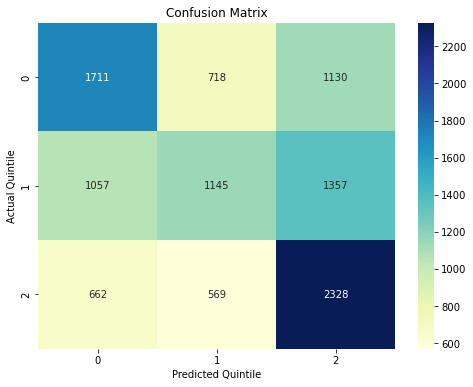

In [46]:
y_pred = model.predict(X_val[xcols])

cm = confusion_matrix(y_val_encoded, y_pred)
print(accuracy_score(y_val_encoded, y_pred))
print(custom_metric(le.inverse_transform(y_val_encoded), le.inverse_transform(y_pred)))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sn.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=ax)
ax.set_xlabel("Predicted Quintile")
ax.set_ylabel("Actual Quintile")
ax.set_title("Confusion Matrix")
plt.show()

In [286]:
model = RandomForestClassifier(
    n_estimators=380,
    max_depth=26,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=26, n_estimators=380, n_jobs=-1,
                       random_state=42)

0.43973026130935655
0.5542919036014081


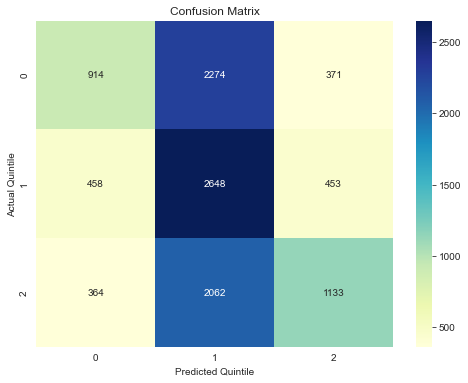

In [287]:
aux_x = X_val
aux_y = y_val

y_pred = model.predict(aux_x)

cm = confusion_matrix(aux_y, y_pred)
print(accuracy_score(aux_y, y_pred))
print(custom_metric(aux_y, y_pred))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sn.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=ax)
ax.set_xlabel("Predicted Quintile")
ax.set_ylabel("Actual Quintile")
ax.set_title("Confusion Matrix")
plt.show()

In [290]:
classification_report(y_pred, aux_y, [0, 1, 2])

Accuracy: 43.97%


,Class,Precision,Recall,F1-score,Prediction Proportion,Target Proportion
0,0,52.649770,25.681371,34.523135,0,0
1,1,37.915235,74.402922,50.232382,0,0
2,2,57.894737,31.834785,41.080493,0,0


---

In [90]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [106]:
import seaborn as sns

def plot_history(history):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    sns.set_style('whitegrid')
    sns.set_palette('husl')

    # Left plot (Accuracy)
    sns.lineplot(data=history.history['accuracy'], ax=ax1)
    sns.lineplot(data=history.history['val_accuracy'], ax=ax1)

    ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax1.tick_params(axis='both', labelsize=10)
    ax1.legend(['Training', 'Validation'], loc='lower right', fontsize=10)

    # Right plot (Loss)
    sns.lineplot(data=history.history['loss'], ax=ax2)
    sns.lineplot(data=history.history['val_loss'], ax=ax2)

    ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Loss', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax2.tick_params(axis='both', labelsize=10)
    ax2.legend(['Training', 'Validation'], loc='upper right', fontsize=10)

    plt.show()


In [304]:
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 512)               33792     
_________________________________________________________________
dropout_28 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_29 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 64)                32832     
_________________________________________________________________
dropout_30 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_50 (Dense)             (None, 3)               

In [305]:
from sklearn.preprocessing import OneHotEncoder

train_encoded = pd.get_dummies(y_train)
val_encoded = pd.get_dummies(y_val)
test_encoded = pd.get_dummies(y_test)
train_encoded, val_encoded = train_encoded.align(val_encoded, join='outer', axis=1, fill_value=0)
train_encoded, test_encoded = train_encoded.align(test_encoded, join='outer', axis=1, fill_value=0)

history = model.fit(
    X_train,
    train_encoded,
    epochs=100,
    batch_size=256,
    validation_data=(X_val, val_encoded),
    callbacks=[
        EarlyStopping(patience=15, restore_best_weights=True)
    ]
)

Epoch 1/100
 1/79 [..............................] - ETA: 25s - loss: 1.1568 - accuracy: 0.3438

2023-04-24 17:37:12.734092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - ETA: 0s - loss: 1.0873 - accuracy: 0.3940

2023-04-24 17:37:13.844774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 2s 16ms/step - loss: 1.0873 - accuracy: 0.3940 - val_loss: 1.0470 - val_accuracy: 0.4418
Epoch 2/100
79/79 [==============================] - 1s 13ms/step - loss: 1.0454 - accuracy: 0.4448 - val_loss: 1.0350 - val_accuracy: 0.4582
Epoch 3/100
79/79 [==============================] - 1s 13ms/step - loss: 1.0295 - accuracy: 0.4620 - val_loss: 1.0292 - val_accuracy: 0.4701
Epoch 4/100
79/79 [==============================] - 1s 12ms/step - loss: 1.0160 - accuracy: 0.4753 - val_loss: 1.0248 - val_accuracy: 0.4733
Epoch 5/100
79/79 [==============================] - 1s 12ms/step - loss: 1.0071 - accuracy: 0.4877 - val_loss: 1.0218 - val_accuracy: 0.4734
Epoch 6/100
79/79 [==============================] - 1s 13ms/step - loss: 0.9974 - accuracy: 0.4930 - val_loss: 1.0242 - val_accuracy: 0.4765
Epoch 7/100
79/79 [==============================] - 1s 12ms/step - loss: 0.9881 - accuracy: 0.5019 - val_loss: 1.0234 - val_accuracy: 0.4807
Epoch 8/100
79/79 

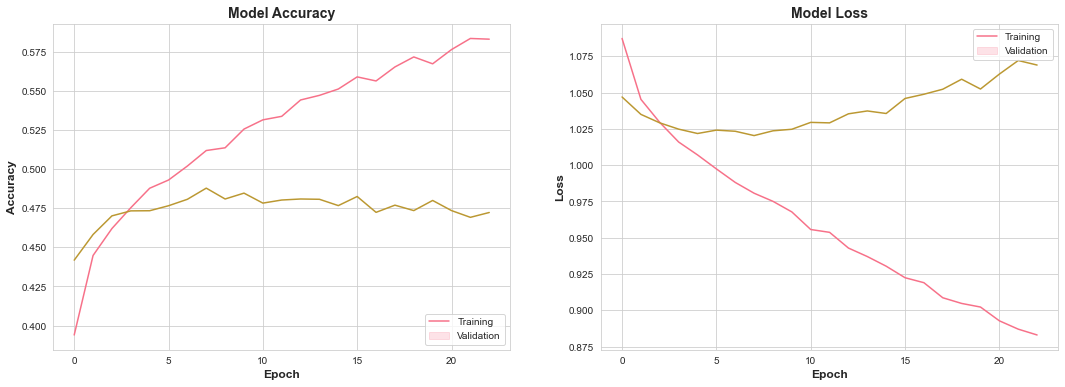

In [306]:
plot_history(history)

In [307]:
from sklearn.metrics import accuracy_score

def plot_confusion_matrix(targets, predictions):
    cm = confusion_matrix(targets, predictions)

    # Plot confusion matrix
    _, ax = plt.subplots(figsize=(8, 6))
    sn.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=ax)
    ax.set_xlabel("Predicted Quintile")
    ax.set_ylabel("Actual Quintile")
    ax.set_title("Confusion Matrix")
    plt.show()

2023-04-24 17:38:04.222320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


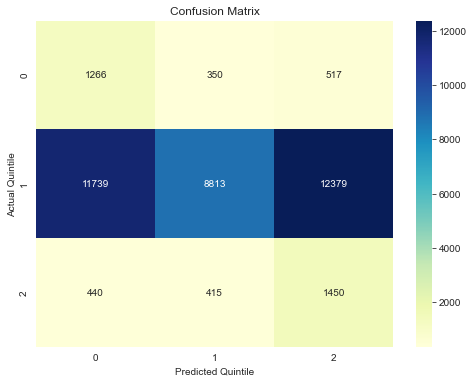

In [308]:
plot_confusion_matrix(
    np.argmax(test_encoded.to_numpy(), axis=1),
    np.argmax(model.predict(X_test), axis=1)
)

In [312]:
pred = np.argmax(model.predict(X_test), axis=1)
targ = np.argmax(test_encoded.to_numpy(), axis=1)

classification_report(pred, targ, [0, 1, 2])

mask = ((pred == 0) | (pred == 2))
((targ == pred) & mask).sum() / mask.sum()

Accuracy: 30.85%


0.09772948076715483

In [313]:
classification_report(pred, targ, [0, 1, 2])

Accuracy: 30.85%


,Class,Precision,Recall,F1-score,Prediction Proportion,Target Proportion
0,0,9.416140,59.353024,16.253691,35.979020,5.707940
1,1,92.012946,26.762018,41.464161,25.630871,88.123846
2,2,10.107347,62.906725,17.416371,38.390109,6.168214


---

In [ ]:
model = RandomForestClassifier(
    n_estimators=380,
    max_depth=26,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

---

In [171]:
import json
from typing import Any, Optional
from dataclasses import dataclass
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score


def custom_metric(target, prediction):
    mask = ((prediction == 'top') | (prediction == 'bottom'))
    return ((target == prediction) & mask).sum() / mask.sum()


@dataclass
class ModelOptimizer:
    model_class: Any
    pbounds: dict
    X: pd.DataFrame
    y: pd.DataFrame
    X_val: pd.DataFrame
    y_val: pd.DataFrame
    verbose: bool = False
    extra_params: Optional[dict] = None
    force_params: Optional[dict] = None
    captured_data: Optional[dict] = None

    @staticmethod
    def get_int_params():
        return [
            "n_estimators", "max_depth", "min_samples_split", "min_samples_leaf",
            "iterations", "depth", "early_stopping_rounds", "max_samples"
        ]

    @staticmethod
    def process_params(params: dict, dtypes: Optional[dict] = None) -> dict:
        for k, v in params.items():
            if dtypes is not None and k in dtypes:
                params[k] = dtypes[k](v)
            elif k in ModelOptimizer.get_int_params():
                params[k] = int(round(v))
        return params

    def catboost_performance(self, **params):
        model: cat.CatBoostClassifier = self.model_class(**params)
        model.fit(
            cat.Pool(self.X, self.y),
            eval_set=cat.Pool(self.X_val, self.y_val),
            plot=False
        )
        y_pred = model.predict(self.X_val)

        return custom_metric(self.y_val.to_numpy(), y_pred.flatten())

    def xgb_performance(self, **params):
        le = LabelEncoder()
        y_train_encoded = le.fit_transform(self.y)
        y_val_encoded = le.transform(self.y_val)

        model = self.model_class(**params)
        model.fit(
            self.X, y_train_encoded,
            eval_set=[(self.X_val, y_val_encoded)],
            verbose=False
        )
        y_pred = model.predict(self.X_val)

        return custom_metric(
            le.inverse_transform(y_val_encoded),
            le.inverse_transform(y_pred)
        )

    def sklearn_performance(self, **params):
        model = self.model_class(**params)
        model.fit(self.X, self.y)
        y_pred = model.predict(self.X_val)

        return custom_metric(self.y_val, y_pred)

    def cv_performance(self, **params) -> float:
        params = ModelOptimizer.process_params(params, dtypes=self.force_params)
        for k, v in self.extra_params.items(): params[k] = v
        if self.verbose: print(json.dumps(params, indent=4))
        
        if self.model_class == cat.CatBoostClassifier:
            return self.catboost_performance(**params)
        elif self.model_class == xgb.XGBClassifier:
            return self.xgb_performance(**params)
        else:
            return self.sklearn_performance(**params)
    
    def add_permanent_params(self):
        self.extra_params = {}

        if self.model_class in [cat.CatBoostClassifier]:
            # self.extra_params['loss_function'] = 'RMSE'
            self.extra_params['iterations'] = 20000
            self.extra_params['early_stopping_rounds'] = 300
            self.extra_params['eval_metric'] = "Accuracy"
            self.extra_params['verbose'] = False

        elif self.model_class in [xgb.XGBClassifier]:
            self.extra_params['n_estimators'] = 10000
            self.extra_params['early_stopping_rounds'] = 50
            self.extra_params['eval_metric'] = "mlogloss"

        elif self.model_class in [RandomForestClassifier]:
            self.extra_params['n_jobs'] = -1
            self.extra_params['verbose'] = False

    def get_final_params(self, params: dict) -> dict:
        params = ModelOptimizer.process_params(params, dtypes=self.force_params)
        self.add_permanent_params()
        for k, v in self.extra_params.items(): params[k] = v
        return params

    def optimize_model(self) -> dict:
        self.add_permanent_params()

        optimizer = BayesianOptimization(
            f=self.cv_performance,
            pbounds=self.pbounds,
            random_state=42,
        )

        optimizer.maximize(init_points=10, n_iter=25)
        return optimizer.max


In [24]:
models = {
    "xgboost": {
        "model": xgb.XGBClassifier,
        "pbounds": {
            "max_depth": (3, 30),
            "learning_rate": (0.001, 0.1),
        },
        "columns": X_train.columns
        # "columns": ['emaS', 'emaM', 'emaL', 'rsi', 'obvSH', 'macd', 'signal', 'market_long_term_trend', 'market_short_term_trend', 'alpha', 'beta', 'market_correlation']
    },
    "random_forest": {
        "model": RandomForestClassifier,
        "pbounds": {
            "n_estimators": (25, 400),
            "max_depth": (3, 30),
            "min_samples_split": (2, 10),
        },
        "columns": X_train.columns
        # "columns": ['emaS', 'emaM', 'emaL', 'rsi', 'obvSH', 'macd', 'signal', 'market_long_term_trend', 'market_short_term_trend', 'alpha', 'beta', 'market_correlation']
    },
    "catboost_full": {
        "model": cat.CatBoostClassifier,
        "pbounds": {
            "depth": (3, 10),
            "learning_rate": (0.005, 0.6),
        },
        "columns": X_train.columns
    },
    "catboost": {
        "model": cat.CatBoostClassifier,
        "pbounds": {
            "depth": (3, 10),
            "learning_rate": (0.005, 0.6),
        },
        "columns": [
            'emaS', 'emaM', 'emaL', 'rsi', 'obvSH', 'macd', 'signal',
            'market_long_term_trend', 'market_short_term_trend', 'alpha', 'beta', 'market_correlation'
        ]
    },
}

In [418]:
best_params, best_results = {}, {}
for model_name, model_info in models.items():
    print(f"Optimizing {model_name}...")

    optimizer = ModelOptimizer(
        model_class=model_info["model"],
        pbounds=model_info["pbounds"],
        X=X_train[model_info["columns"]],
        y=y_train,
        X_val=X_val[model_info["columns"]],
        y_val=y_val,
        verbose=False,
        force_params=model_info.get("force_types")
    )
    best_result = optimizer.optimize_model()
    
    best_params[model_name] = best_result["params"]
    best_results[model_name] = best_result["target"]


Optimizing xgboost...
|   iter    |  target   | learni... | max_depth |
-------------------------------------------------
| 1         | 0.4398    | 0.03808   | 28.67     |
| 2         | 0.4537    | 0.07347   | 19.16     |
| 3         | 0.479     | 0.01645   | 7.212     |
| 4         | 0.4532    | 0.00675   | 26.39     |
| 5         | 0.4237    | 0.06051   | 22.12     |
| 6         | 0.4512    | 0.003038  | 29.19     |
| 7         | 0.4671    | 0.08341   | 8.733     |
| 8         | 0.4715    | 0.019     | 7.952     |
| 9         | 0.4564    | 0.03112   | 17.17     |
| 10        | 0.4795    | 0.04376   | 10.86     |
| 11        | 0.4849    | 0.001     | 5.414     |
| 12        | 0.4922    | 0.08914   | 3.25      |
| 13        | 0.4728    | 0.1       | 13.21     |
| 14        | 0.4874    | 0.0957    | 4.155     |
| 15        | 0.4914    | 0.001     | 3.0       |
| 16        | 0.4752    | 0.001     | 11.94     |
| 17        | 0.4791    | 0.001     | 14.94     |
| 18        | 0.4914    | 0.

In [32]:
model = cat.CatBoostClassifier(
    iterations=20000,
    early_stopping_rounds=300,
    learning_rate=0.128,
    depth=9,
    eval_metric='Accuracy',
    random_seed=42
)

summary = model.select_features(
    cat.Pool(X_train, y_train),
    eval_set=cat.Pool(X_val, y_val),
    features_for_select='0-64',
    num_features_to_select=15,
    steps=24,
    algorithm=cat.EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=cat.EShapCalcType.Regular,
    train_final_model=True,
    logging_level='Silent',
    plot=True
)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [35]:
summary['selected_features_names']

['v',
 'n',
 'diff',
 'emaS',
 'emaM',
 'pc',
 'rsi',
 'rsid',
 'ewm_26',
 'macd',
 'signal',
 'macds',
 'time_embed_day_sin',
 'market_change',
 'beta']

In [1]:
print(json.dumps(best_results, indent=4))
print(json.dumps(best_params, indent=4))

NameError: name 'json' is not defined

In [ ]:

 26.34     | 2.09      | 381.3    
rf_classifier = RandomForestClassifier(
    n_estimators=380,
    
    random_state=42
)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_val)

KeyboardInterrupt: 

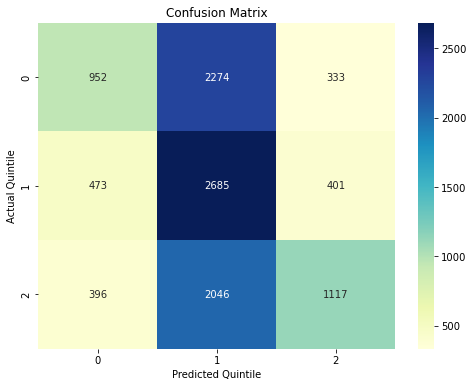

In [288]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sn.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=ax)
ax.set_xlabel("Predicted Quintile")
ax.set_ylabel("Actual Quintile")
ax.set_title("Confusion Matrix")
plt.show()

In [ ]:
classification_report(pred, targ, [0, 1, 2])

In [289]:
accuracy_score(y_val, y_pred)

0.44525615809684366

In [308]:
(1117 + 952) / (1117 + 401 + 333 + 952 + 473 + 396)

0.5634531590413944

In [301]:
mask.sum()

7118

In [325]:
((y_val == y_pred) & mask).sum()

2069

In [355]:
pd.DataFrame([[1], [0], [1]]).to_numpy().flatten().shape

(3,)

In [363]:
y_val.values

['middle', 'middle', 'middle', 'middle', 'middle', ..., 'bottom', 'bottom', 'bottom', 'bottom', 'bottom']
Length: 10677
Categories (3, object): ['bottom', 'middle', 'top']